In [66]:
# .libPaths("~/R/prs-libs")
.libPaths("/home/daniel/R/x86_64-pc-linux-gnu-library/4.2")
library(Sleuth2)
library(ggplot2)
library(cowplot)
library(olsrr)
library(moments)
library(vtable)
library(car)

In [67]:
#install.packages("Sleuth2", dependencies=T, lib="/home/ivan/R/prs-libs")
#install.packages("Sleuth2", dependencies=T)

#### Příprava dat

Pomocí vzorce vypočítáme, jakou úlohu budeme řešit.

In [68]:
K = 20
L = nchar("Yannick")
M = (( (K+L)*47 ) %% 11 ) + 1
M

[1] 5

Číslo 5 odpovídá datasetu *case1202*, který zkoumá platy zaměstnaců banky z let 1965 - 1975. Banka byla zažalována kvůli diskriminaci na základě pohlaví, takže je možné, že platy jednoho pohlaví budou nižší, než platy opačného. To se mimo jiné budeme také snažit prozkoumat.

Neprve si ale ještě přejmenujeme sloupec *Sal77* na *Sal75*. Podle manuálu se totiž jedná o plat z března 1975, ne 1977, tak ať jsou názvy konzistentní.

In [69]:
df = case1202
names(df)[names(df) == 'Sal77'] = 'Sal75'
df <- transform(df, SalInc=Sal75-Bsal)

Dataset obsahuje celkem 93 řádků a 7 sloupců:

* Bsal - Roční nástupní výše platu.
* Sal75 - Plat v březnu 1975.
* Sex - Pohlaví zaměstnance.
* Senior - Počet měsíců od prvního nástupu do práce (jak dlouho v této bance pracují).
* Age - Věk zaměstnance v měsících.
* Educ - Vzdělání zaměstnance v rocích.
* Exper - Přechozí pracovní zkušenosti před nástupem do této banky.

V manuálu to není napsané, ale předpokládáme, že výše platů je uvedená v USD.

Podíváme se na prvních pár záznamů a souhrné informace o datasetu.

In [70]:
head(df)
summary(df)

,Bsal,Sal75,Sex,Senior,Age,Educ,Exper,SalInc
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5040,12420,Male,96,329,15,14.0,7380
2,6300,12060,Male,82,357,15,72.0,5760
3,6000,15120,Male,67,315,15,35.5,9120
4,6000,16320,Male,97,354,12,24.0,10320
5,6000,12300,Male,66,351,12,56.0,6300
6,6840,10380,Male,92,374,15,41.5,3540


      Bsal          Sal75           Sex         Senior           Age       
 Min.   :3900   Min.   : 7860   Female:61   Min.   :65.00   Min.   :280.0  
 1st Qu.:4980   1st Qu.: 9000   Male  :32   1st Qu.:74.00   1st Qu.:349.0  
 Median :5400   Median :10020               Median :84.00   Median :468.0  
 Mean   :5420   Mean   :10393               Mean   :82.28   Mean   :474.4  
 3rd Qu.:6000   3rd Qu.:11220               3rd Qu.:90.00   3rd Qu.:590.0  
 Max.   :8100   Max.   :16320               Max.   :98.00   Max.   :774.0  
      Educ           Exper           SalInc     
 Min.   : 8.00   Min.   :  0.0   Min.   : 2280  
 1st Qu.:12.00   1st Qu.: 35.5   1st Qu.: 3720  
 Median :12.00   Median : 70.0   Median : 4680  
 Mean   :12.51   Mean   :100.9   Mean   : 4973  
 3rd Qu.:15.00   3rd Qu.:144.0   3rd Qu.: 5940  
 Max.   :16.00   Max.   :381.0   Max.   :10320  

V datasetu jsou záznamy o 61 ženách a 32 mužích s věky od 280 měsíců (23 let) do 774 měsíců (64 let), přičemž průměrný věk je 474 měsíců (39 let).

Minimální doba vzdělání zaměstnanců je 8 let a maximální 16 let. Do práce někteří nastoupili i s nulovou předchozí zkušeností, nebo naopak až s 381 měsíci (31 let) zkušeností.

Zaměstnanci v bance pracovali průměrně 82 měsíců (skoro 7 let).

Výše nástupního platu se pohybuje od 3900 USD do 8100 USD, kdežto v roce 1975 v rozmezí od 7860 USD do 16320 USD. Je vidět, že se plat celkem výrazně zvedal. Průměrný nástupní plat je 5420 USD a průměrný plat v roce 1975 je 10393 USD, tedy téměř dvakrát vyšší.

In [71]:
summ <- c('mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 'median(x)', 'pctile(x)[75]', 
          'max(x)', 'IQR(x)', 'skewness(x)', 'kurtosis(x)-3')
sumtable(df, out="return", group="Sex", group.long=T, summ=summ, factor.numeric=TRUE)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex: Female,,,,,,,,,,
Bsal,5138.9,539.871,3900,4800,5220,5400,6300,600,-0.076,-0.36
Sal75,9717,1253.001,7860,8820,9600,10320,13560,1500,1.051,1.14
Senior,81.6,10.53,65,72,82,89,98,17,-0.028,-1.234
Age,500.8,145.068,280,349,528,604,774,255,0.028,-1.251
Educ,12,2.309,8,12,12,12,16,0,-0.312,-0.447
Exper,99.8,85.402,0,36,82,144,381,108,1.027,0.771
SalInc,4578.2,1333.874,2280,3540,4440,5220,8760,1680,0.905,0.954
,,,,,,,,,,


Vzhledem k tomu, že tématem datasetu je nerovnost v platech mužů a žen, jsme udělali shrnutí i podle těchto dvou kategorií. Na první pohled vidíme, že ženy při nástupu dostaly menší plat, v roce 1975 měly nižší platy a jejich platy méně rostly. Muži jsou mladší než ženy, ale pracovní zkušenosti a senioritu v rámci banky mají podobnou. Sice to je jen spekulace, ale tuto skutečnost by mohlo ovlivňovat to, že většinou ženy musely přerušit své zaměstnání kvůli dětem. Je patrné, že muži mají lehce delší vzdělání, které by také mělo korelovat s výší platu. Otázkou je, jaká z těchto vlastností má na výši platu nejvyšší vliv - zda-li to je hlavně pohlaví, nebo to třeba může být vzděláním?

Pro lepší přehled by bylo dobré využít pár vizualizací.

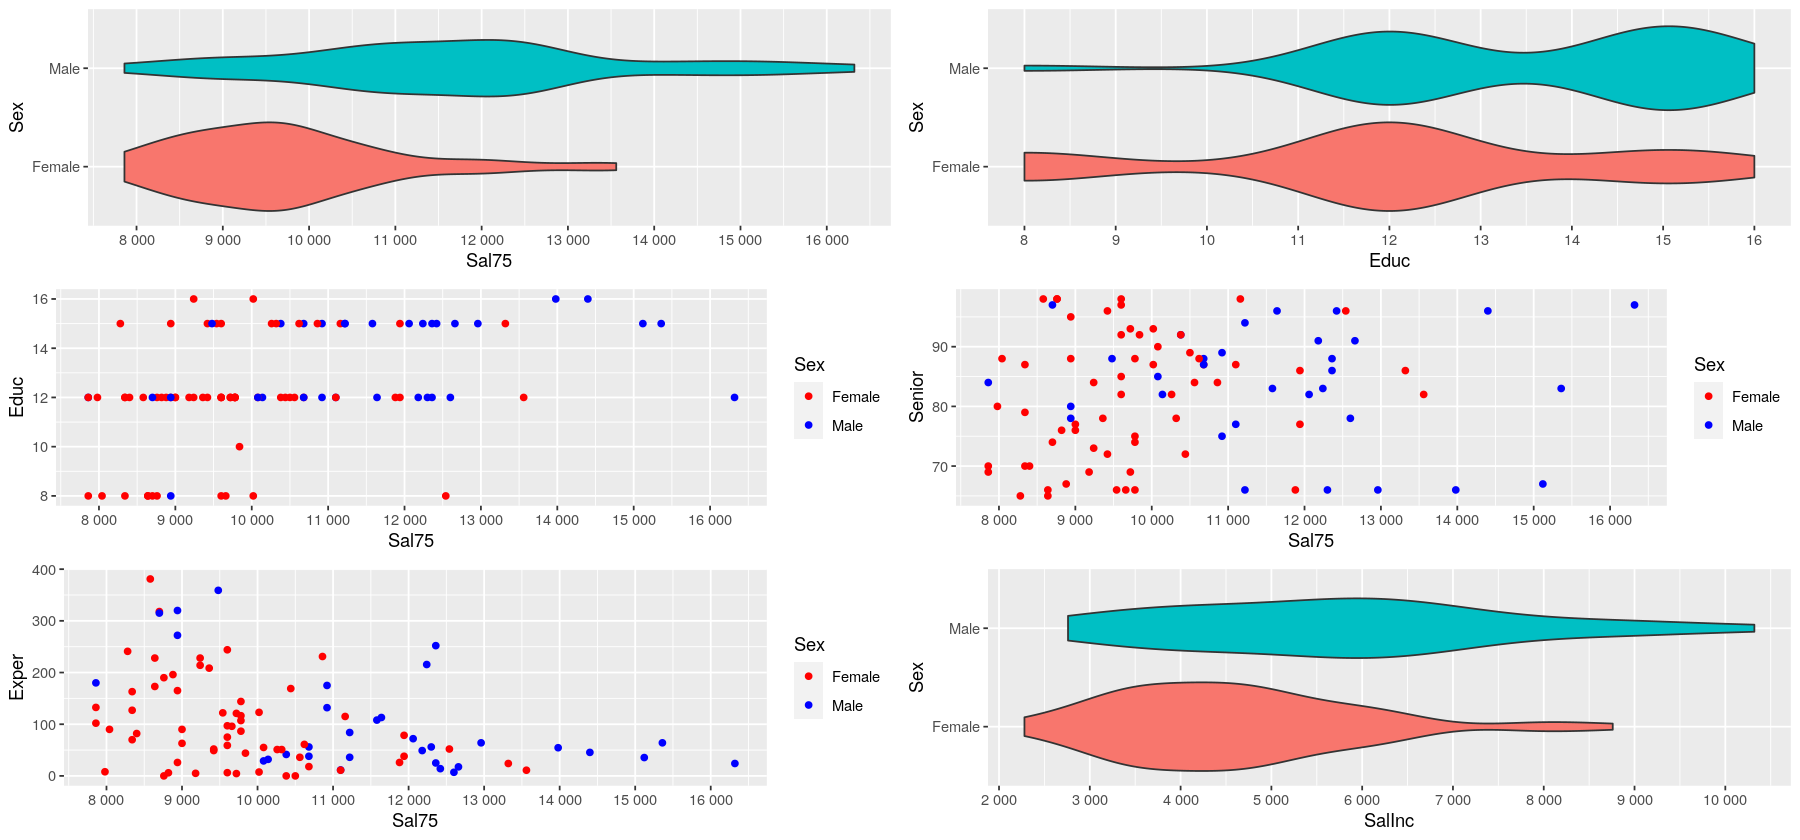

In [72]:
options(repr.plot.width = 15, repr.plot.height = 7)
p = ggplot(df, aes(x=Sal75, y=Sex, fill=Sex)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10)
q = ggplot(df, aes(x=Educ, y=Sex, fill=Sex)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10)
r = ggplot(df, aes(x=Sal75, y=Educ, color=Sex)) +
        geom_point() + 
        scale_x_continuous(labels = scales::number, n.breaks=10) +
        scale_color_manual(values = c("Male" = "blue", "Female" = "red"))
s = ggplot(df, aes(x=Sal75, y=Senior, color=Sex)) +
        geom_point() + 
        scale_x_continuous(labels = scales::number, n.breaks=10) +
        scale_color_manual(values = c("Male" = "blue", "Female" = "red"))
t = ggplot(df, aes(x=Sal75, y=Exper, color=Sex)) +
        geom_point() + 
        scale_x_continuous(labels = scales::number, n.breaks=10) +
        scale_color_manual(values = c("Male" = "blue", "Female" = "red"))
u = ggplot(df, aes(x=SalInc, y=Sex, fill=Sex)) +
        geom_violin(show.legend=F) + 
        scale_x_continuous(labels = scales::number, n.breaks=10)
plot_grid(p, q, r, s, t, u, ncol=2)

Z grafu rozdělení platů seskupeného podle pohlaví je vidět, že muži v bance mají vyšší platy než ženy. Z grafu vzdělaní je vidět, že muži častěji absolvovali delší vzdělání, které by mohlo vést k větším příjmům. To sice je obecně pravda, ale neznamená to, že pohlaví zaměstnanců nemá vliv na plat, jak je ilustrováno v třetím grafu, ze kterého je patrné, že vyšší vzdělání vede v průměru k vyšším příjmům, ale je vidět, že u podobně vzdělaných mužů a žen je stále rozdíl v příjmech. Podobně je to i senioritou a expertízou - i přesto že jsou na tom obě pohlaví podobně, dostávají muži vyšší platy.

### Úloha 2

Prozkoumáme, jestli je nějaká závislot výše platu v roce 1975 na věku zaměstnanců.

In [73]:
fit_numeric = lm(Sal75 ~ Age, df)

Warning message in predict.lm(fit_numeric, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


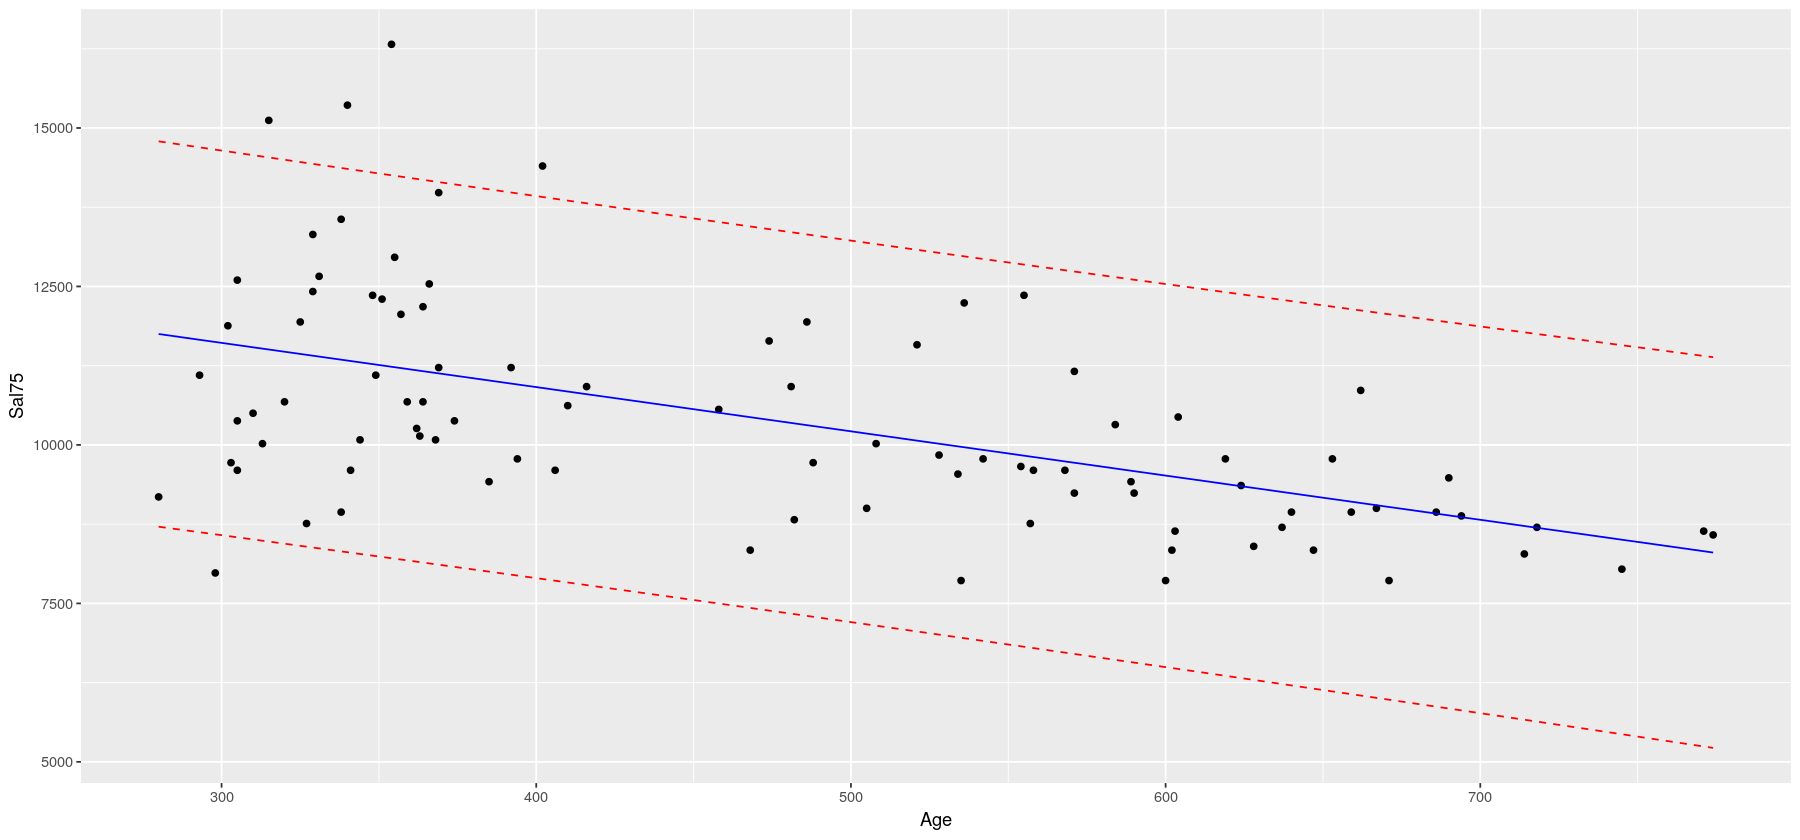

In [74]:
tmp = predict(fit_numeric, interval="prediction")
df_numeric = cbind(df, tmp)
ggplot(df_numeric, aes(x=Age, y=Sal75)) +
    geom_point() +
    geom_line(aes(y=fit), color="blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

Z grafu je vidět, že nějaká závislost tam je. S rostoucím věkem zaměstnanců jejich plat překvapivě klesá. Nemůžeme s jistotou říci příčinu této závislosti, ale například to může být to, že si banka více cení mladších zaměstnanců kvůli tomu, že mohou potenciálně být flexibilnější a ochotnější se přizpůsobovat. Pro lepší porozumění modelu se podíváme na *summary*. Je potřeba mít na paměti, že je o dost více žen než mužů a tato tendence by mohla existovat jen u žen a být opačná u mužů. V tuhle chvíli tuto možnost necháme být a rozebereme to v pozdějších úlohách. 

In [75]:
summary(fit_numeric)


Call:
lm(formula = Sal75 ~ Age, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3643.9 -1030.3  -168.0   847.8  5086.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13703.562    553.968  24.737  < 2e-16 ***
Age            -6.979      1.120  -6.229 1.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1507 on 91 degrees of freedom
Multiple R-squared:  0.2989,	Adjusted R-squared:  0.2912 
F-statistic:  38.8 on 1 and 91 DF,  p-value: 1.429e-08


Odhad interceptu je 13703 a odhad koeficientu věku je zhruba -7. To nám říká, že při nulovém věku by odhadovaný plat byl 13703 USD a s každým dalším měsícem věku by klesal o 7 USD.

Z *p* hodnoty u koeficientů je vidět, že test o jejich nulovosti vychází významně, takže vysvětlovaná proměnná na vybráné regresoru závisí.

Rezidua jsou trochu výchýlené na jednu stranu - Může to být vychýlené managementem - ti berou často o dost více než řadoví zaměstnanci a vysvětlovalo by to vysoká kladná rezidua. Průměrně jsou ale záporná rezidua vyšší, jelikož pár vysoce placených zaměstnanců táhne průměr nahoru a většina zaměstnanců poté má plat nižší než odhad. 

Koeficient determinace vychází 0.2989. Určuje jak dobře model předpovídá variabilitu vysvětlované proměnné (0 znamená, že vůbec, jen se řídí průměrem, 1 znamená, že model perfektně odhaduje hodnoty vysvětlované proměnné, takže si dobře poradí i s odlehlými hodnotami). Hodnota 0.2989 znamená, že má náš model chybu oproti průměrovému modelu menší jen o ~30%, takže se nechová o moc lépe než průměr. To tedy není moc slavný výsledek. Adjustovaný koeficient determinace, který penalizuje složitost modelu, vychází ještě o něco hůř. 

Tyto hodnoty nejsou nejlepší a i z grafu výše je vidět, že odhady nejsou moc přesné. To je vidět i z pásu spolehlivosti pro náš model, který je také dost široký. Věk vysvětluje chování platu v roce 1975 pouze z části. To dáva poměrně smysl, jelikož věk není zrovna dobrý ukazatel schopností a kompetencí. Roli může také hrát vzdělání, a mnoho dalších aspektů, které v tomto modelu nejsou zohledněny (a některé ani nejsou v datasetu, chybí ukazatel kompetence, schopností, výše pozice).

### Úloha 3

Dále prozkoumáme závlislost vysvětlované proměnné na pohlaví, nejprve jednodnoduchým boxplotem.

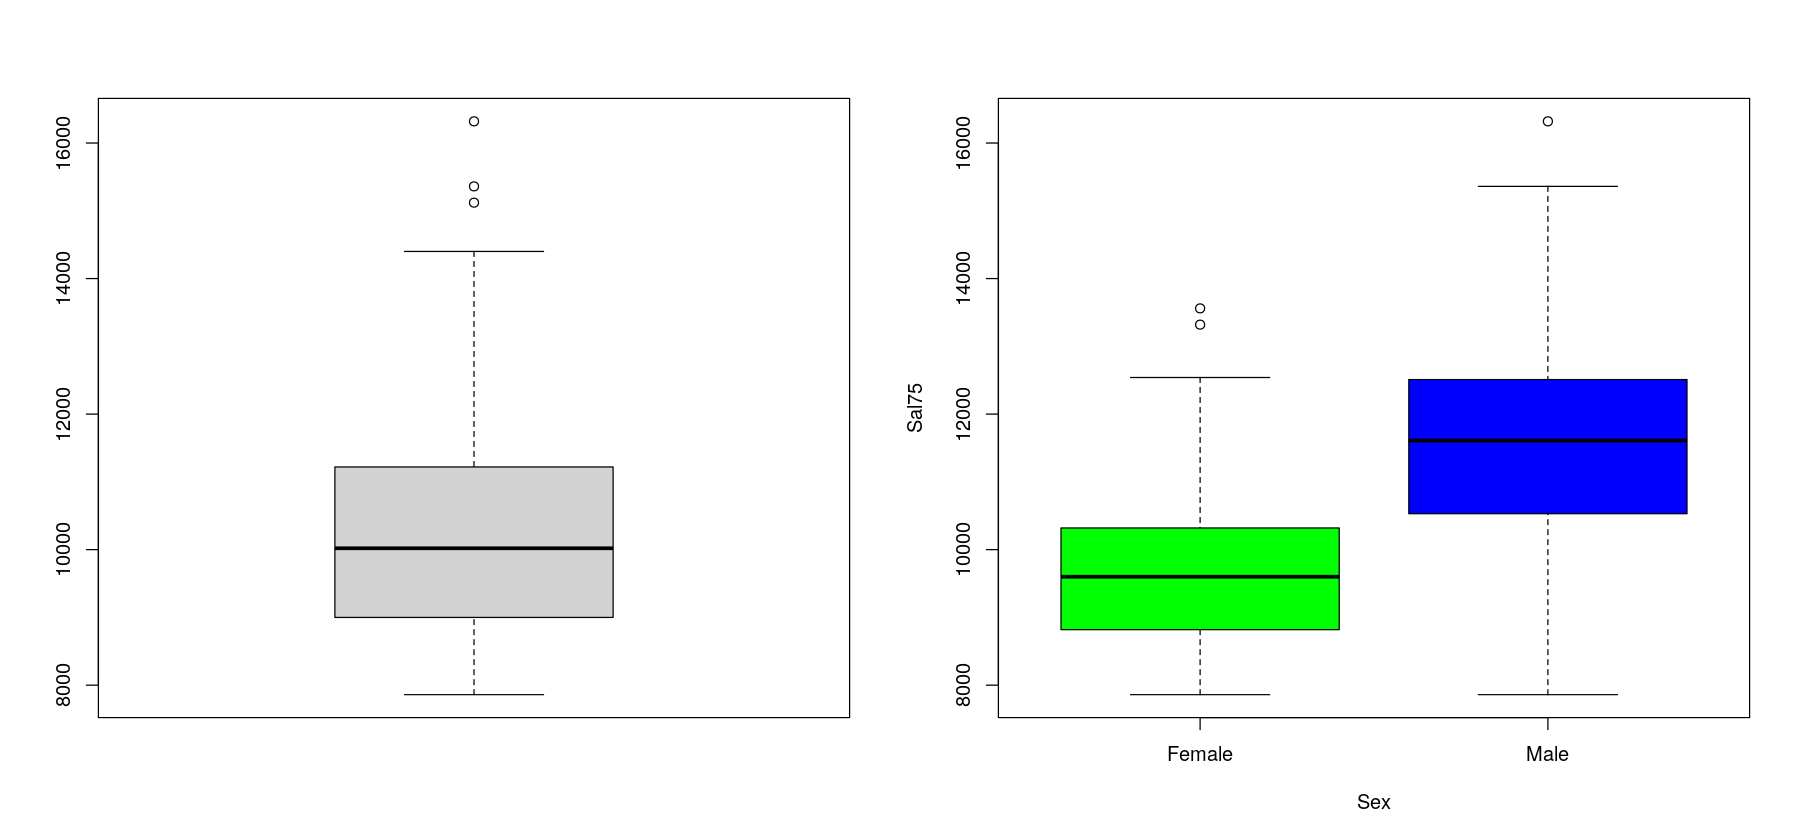

In [76]:
par(mfrow=c(1,2))
boxplot(df$Sal75)
boxplot(Sal75~Sex,col=c("green","blue"), data=df)

Hned na první pohled je vidět, že platy mužů jsou výrazně vyšší, než platy žen. Medián u mužů je lehce pod 12000 USD, kdežto u žen pouze kousek pod 10000 USD. 

Na levém grafu, kde je znázorněn plat obou pohlaví dohromady, to vypadá, že celkový medián je podobný, jako medián platů samotných žen, ale to je dáno tím, že žen je v datasetu dvakrát více než mužů.

Podíváme se na hodnoty v číslech.

In [77]:
by(df$Sal75,df$Sex,summary)

df$Sex: Female
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7860    8820    9600    9717   10320   13560 
------------------------------------------------------------ 
df$Sex: Male
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7860   10605   11610   11681   12465   16320 

Čísla odpovídají boxplotu výše. Medián (i celé mezikvartilové rozpětí) je u mužů posunuté o dva tisíce USD výše, než u žen.

Dále zkusíme otestovat shodu středních hodnot pomocí regresního modelu.

In [78]:
fit_sex = lm(df$Sal75~df$Sex)
summary(fit_sex)


Call:
lm(formula = df$Sal75 ~ df$Sex)

Residuals:
    Min      1Q  Median      3Q     Max 
-3821.3  -957.0  -117.0   678.7  4638.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9717.0      196.2  49.526  < 2e-16 ***
df$SexMale    1964.2      334.5   5.872 6.92e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1532 on 91 degrees of freedom
Multiple R-squared:  0.2748,	Adjusted R-squared:  0.2669 
F-statistic: 34.49 on 1 and 91 DF,  p-value: 6.925e-08


I z tohoto modelu je vidět to samé, co výše. Odhad střední hodnoty platů u žen je 9717 USD a u mužů je o 1964 USD vyšší (odhad mužského platu se získá tak, že se vezme intercept - střední hodnota ženského platu - a přičte se k němu 1964).

Zároveň je vidět, že test o nulovosti příznaků vychází významně, takže všechny příznaky přispívají k odhadu vysvětlované proměnné.

Také si můžeme všimnout, že i když model predikuje plat pouze na základě pohlaví, tak má adjustovaný koeficient determinace hodnotu 0.2669, což je skoro stejně jako u modelu výše, kde se plat predikoval pomocí věku.

Přejdeme k metodě analýzy rozptylu.

In [79]:
aov(data=df, Sal75~Sex)

Call:
   aov(formula = Sal75 ~ Sex, data = df)

Terms:
                      Sex Residuals
Sum of Squares   80978301 213680641
Deg. of Freedom         1        91

Residual standard error: 1532.364
Estimated effects may be unbalanced

Součet čtverců vysvětlený rozdíly průměrů mužů a žen je asi 80 mil. A reziduální součet čtverců (variabilita, kterou model nebyl schopen podchytit) je zhruba 213 mil. Z toho lze soudit, že hodnoty platů žen a mužů budou mít rozdílné střední hodnoty, ale model spoléhající se jen na pohlaví nebude úplně přesný, jelikož je v jednotlivých kategoriích velká variabilita. Rozdíl ve středních hodnotách kategorií otestujeme pomocí F-testu analýzy rozptylu, který má za nulovou hypotézu shodu středních hodnot jednotlivých kategorií.

In [80]:
anova(fit_sex)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
df$Sex,1,80978301,80978301,34.48616,6.924807e-08
Residuals,91,213680641,2348139,NA,NA


Vzhledem k tomu, že je p hodnota prakticky nulová na hladině významnosti 𝛼 = 5% zamítneme nulovou hypotézu ve prospěch alternativy, že střední hodnoty platů jsou pro muže a ženy odlišné. Test potvrzuje naší domněnku, že mají muži a ženy rozdílně vysokou střední hodnotu platu, i když se ve výši platu odráží mnoho dalších faktorů.

### Úloha 4

Vytvoříme si další model, ve kterém zkombinuje oba výše použité příznaky. 

In [81]:
fit_mix = lm(Sal75~Age*Sex, df)

Warning message in predict.lm(fit_mix, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


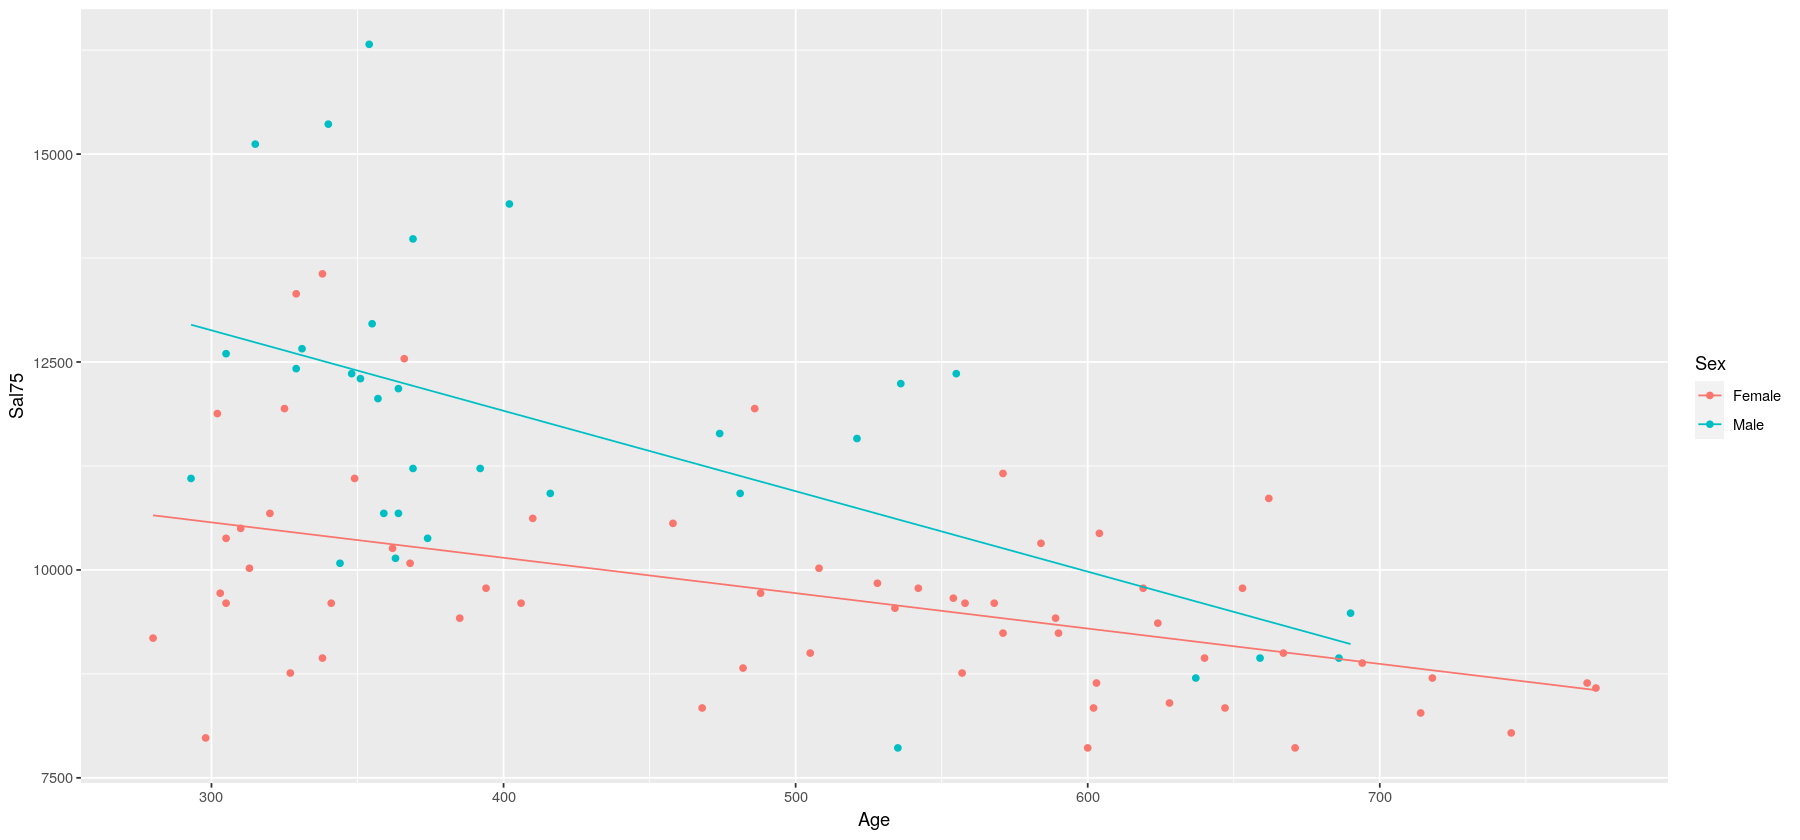

In [82]:
tmp = predict(fit_mix, interval="prediction")
df_mix = cbind(df, tmp)
ggplot(df_mix, aes(x=Age, y=Sal75, group=Sex, color=Sex)) +
    geom_point() +
    geom_line(aes(y=fit))

Predikce vypadají o něco lépe než v modelu, kde byl pouze věk, ale pořád to není úplně nejlepší. Na druhou stranu jde hezky pozorovat, že mužský plat bývá výrazně vyšší, než u žen a je stejně jako u druhého úkolu vidět, že s věkem u obou pohlaví s věkem lehce klesá výše platu.

Podíváme se na hodnoty jednotlivých koeficientů a koeficient determinace.

In [83]:
summary(fit_mix)


Call:
lm(formula = Sal75 ~ Age * Sex, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2747.7  -776.0   -87.3   516.5  3961.7 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11847.933    604.725  19.592  < 2e-16 ***
Age            -4.255      1.160  -3.666 0.000418 ***
SexMale      3934.132   1069.209   3.679 0.000400 ***
Age:SexMale    -5.417      2.319  -2.336 0.021721 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1304 on 89 degrees of freedom
Multiple R-squared:  0.4864,	Adjusted R-squared:  0.4691 
F-statistic: 28.09 on 3 and 89 DF,  p-value: 7.122e-13


Intercept vychází 11847. To znamená, že při nulovém věku se plat pro ženy odhaduje touto hodnotou. Pokud bychom chtěli stejný odhad u mužů, museli bychom navíc přičíst hodnotu *SexMale*. Odhadovaný plat pro muže nulového věku je tedy o 3934 USD vyšší, než pro ženy. 

Když se potom podíváme, jak se vysvětlovaná proměnná mění s věkem, vidíme, že u žen s každým dalším měsícem odhad platu klesá o 4.2 USD, kdežto u mužů o dalších 5.4 USD navíc, takže celkem o 9.6 USD.

To odpovídá grafu výše - přímka, která odhaduje mužský plat, začíná výše než u žen, ale zase rychleji klesá.

*p* hodnoty u všech koeficientů jsou menší než 0.05, takže u všech na standartní hladině zamítáme hypotézu o jejich nulovosti ve prospěch alternativní hypotézy, že nulové nejsou. To znamená, že všechny příznaky (nebo jejich kombinace) jsou užitečné a zlepšují kvalitu modelu)

Adjustovaný koeficient determinace vyšel 0.4691, což je téměř dvojnásobné zlepšení oproti předchozím modelům a odráží to fakt, že v platu hraje roli více faktorů. Pořád je ale poměrně nízký a nejsme stále schopni dobře podchytit variabilitu modelu o což se pokusíme v následující části.

### Úloha 5

Nejprve zkusíme složitý model, který zkouší různé interakce. Vybereme předchozí regresory `Age` `Sex` a přidáme spojité regresory `Educ`, `Exper` a `Senior`.

In [84]:
fit_all = lm(Sal75~Age*Sex*Educ*Exper*Senior, df)
summary(fit_all)


Call:
lm(formula = Sal75 ~ Age * Sex * Educ * Exper * Senior, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2565.8  -508.2     6.5   427.1  3210.7 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                   -1.230e+05  9.696e+04  -1.268  0.20954   
Age                            1.944e+02  1.701e+02   1.143  0.25755   
SexMale                        4.844e+05  3.192e+05   1.518  0.13429   
Educ                           1.191e+04  8.156e+03   1.460  0.14935   
Exper                          6.160e+02  7.059e+02   0.873  0.38625   
Senior                         1.443e+03  1.083e+03   1.333  0.18759   
Age:SexMale                   -2.064e+03  9.988e+02  -2.067  0.04299 * 
Age:Educ                      -1.838e+01  1.440e+01  -1.276  0.20671   
SexMale:Educ                  -2.776e+04  2.265e+04  -1.225  0.22517   
Age:Exper                     -7.850e-01  1.104e+00  -0.711  0.47982   
SexMale:Exper            

Při zahrnutí všech možných interakcí jsou reziduály nižší než u našich předchozích modelů a koeficient determinace je vyšší, což naznačuje vyšší přesnost modelu. Když se ale podíváme na adjustovaný koeficient determinace, vidíme, že není o moc lepší než náš předchozí model a mohlo by to naznačovat přetrénovanost našeho modelu. Zkusíme model tedy zjednodušit, to že bude případně o trochu horší nám nevadí, bude alespoň interpretovatelný. Natrénujeme si model s regresory ***Age***, ***Sex***, ***Educ***, ***Exper*** a ***Senior***. Zahrneme také interakci mezi ***age*** a ***sex***, jelikož nám v předchozí úloze vyšla významně.

In [85]:
fit_final = lm(Sal75~Age*Sex+Educ+Exper+Senior, df)
summary(fit_final)


Call:
lm(formula = Sal75 ~ Age * Sex + Educ + Exper + Senior, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2583.7  -846.3   -95.9   567.5  4164.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9328.6175  1654.9660   5.637 2.16e-07 ***
Age           -4.1418     1.8159  -2.281  0.02503 *  
SexMale     3641.0816  1147.0951   3.174  0.00209 ** 
Educ         153.5293    63.1643   2.431  0.01715 *  
Exper          0.5761     2.9457   0.196  0.84540    
Senior         6.9642    13.5718   0.513  0.60917    
Age:SexMale   -5.3107     2.5951  -2.046  0.04377 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1280 on 86 degrees of freedom
Multiple R-squared:  0.5219,	Adjusted R-squared:  0.4886 
F-statistic: 15.65 on 6 and 86 DF,  p-value: 4.64e-12


Vidíme, že se nám trochu zvětšily reziduály a s nimi nám i klesnul koeficient determinace, ale podstatné je, že adjustovaný koeficient determinace se moc nezhoršil. Předpokládejme normalitu odchylek a otestujme, jestli lze redukovat model s interakcemi na jednodušší. Nevýznamně vyšly regresory ***Exper*** a ***Senior***. Je pravděpodobné, že  tyto dva regresory spolu s věkem mezi sebou korelují.

In [86]:
cor(model.matrix(fit_final))

Warning message in cor(model.matrix(fit_final)):
“the standard deviation is zero”


,(Intercept),Age,SexMale,Educ,Exper,Senior,Age:SexMale
(Intercept),1,NA,NA,NA,NA,NA,NA
Age,NA,1.00000000,-0.26175147,-0.22525298,0.79787476,-0.18448263,-0.09502744
SexMale,NA,-0.26175147,1.00000000,0.32731475,0.01697046,0.09776089,0.94836990
Educ,NA,-0.22525298,0.32731475,1.00000000,-0.10117309,0.05984385,0.26097308
Exper,NA,0.79787476,0.01697046,-0.10117309,1.00000000,-0.07466085,0.21471409
Senior,NA,-0.18448263,0.09776089,0.05984385,-0.07466085,1.00000000,0.12363651
Age:SexMale,NA,-0.09502744,0.94836990,0.26097308,0.21471409,0.12363651,1.00000000


Regresor ***Exper*** má silnou pozitivní korelaci s věkem a jeho P-hodnota je pravděpodobně kvůli tomu nejvyšší a měl by mít nejmenší vliv na predikci. Korelace věku a zkušeností dává smysl, získat zkušenosti nějakou dobu trvá a proto více zkušenostem bude odpovídat vyšší věk zaměstnance. Zkusíme ***Exper*** proto odebrat, ale nejdrříve ještě otestujeme, zda-li se nám model moc nezhoršil oproti počátečnímu. 

In [87]:
anova(fit_final,fit_all)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,86,140863296,NA,NA,NA,NA
2,61,91969722,25,48893573,1.297169,0.2032376


I přesto, že rozdíl mezi reziduálními součty čtverců je poměrně vysoký, podle p hodnoty, která vyšla cca 0.20, mezi modely není statisticky významný rozdíl a vystačíme si tedy s jednodušším modelem. Přejdeme tedy k dalšímu zjednodušování modelu, začneme regresorem ***Exper***.

In [88]:
fit_final_2 = lm(Sal75~Age*Sex+Educ+Senior, df)
summary(fit_final_2)


Call:
lm(formula = Sal75 ~ Age * Sex + Educ + Senior, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2592.1  -845.6   -76.9   556.9  4154.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9235.066   1575.552   5.861 8.05e-08 ***
Age           -3.872      1.173  -3.302  0.00139 ** 
SexMale     3569.310   1080.789   3.303  0.00139 ** 
Educ         154.505     62.618   2.467  0.01557 *  
Senior         7.015     13.494   0.520  0.60451    
Age:SexMale   -5.092      2.329  -2.187  0.03146 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1273 on 87 degrees of freedom
Multiple R-squared:  0.5217,	Adjusted R-squared:  0.4942 
F-statistic: 18.98 on 5 and 87 DF,  p-value: 1.018e-12


Model má dokonce o trochu lepší adjustovaný koeficient determinace a zároveň regresor ***Senior*** stále vychází nevýznamně. Zkusíme ho odstranit také. 

In [89]:
fit_final_3 = lm(Sal75~Age*Sex+Educ, df)
summary(fit_final_3)


Call:
lm(formula = Sal75 ~ Age * Sex + Educ, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2600.4  -794.3   -73.0   533.1  4256.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9871.778    986.878  10.003 3.54e-16 ***
Age           -4.022      1.132  -3.553 0.000614 ***
SexMale     3461.640   1056.348   3.277 0.001503 ** 
Educ         155.385     62.335   2.493 0.014548 *  
Age:SexMale   -4.834      2.266  -2.133 0.035672 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1267 on 88 degrees of freedom
Multiple R-squared:  0.5202,	Adjusted R-squared:  0.4984 
F-statistic: 23.86 on 4 and 88 DF,  p-value: 2.203e-13


Adjustovaný koeficient determinace je opět o kousek vyšší. Nyní již všechny regresory vychází významně. Měli bychom nyní otestovat, zda-li je mezi tímto modelem a počátečním modelem statisticky významný rozdíl.

In [90]:
anova(fit_final_3,fit_all)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,88,141363656,NA,NA,NA,NA
2,61,91969722,27,49393933,1.213374,0.2619713


Mezi počátečním, obsáhlým modelem a finálním modelem není statisticky významný rozdíl. Můžeme tedy používat tento zjednodušený model a znovu se na něj podíváme a zhodnotíme ho.

In [91]:
fit_final = lm(Sal75~Age*Sex+Educ, df)
summary(fit_final)


Call:
lm(formula = Sal75 ~ Age * Sex + Educ, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2600.4  -794.3   -73.0   533.1  4256.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9871.778    986.878  10.003 3.54e-16 ***
Age           -4.022      1.132  -3.553 0.000614 ***
SexMale     3461.640   1056.348   3.277 0.001503 ** 
Educ         155.385     62.335   2.493 0.014548 *  
Age:SexMale   -4.834      2.266  -2.133 0.035672 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1267 on 88 degrees of freedom
Multiple R-squared:  0.5202,	Adjusted R-squared:  0.4984 
F-statistic: 23.86 on 4 and 88 DF,  p-value: 2.203e-13


In [92]:
round(fit_final$coef, 3)

(Intercept)         Age     SexMale        Educ Age:SexMale 
   9871.778      -4.022    3461.640     155.385      -4.834

Nejvýznamější regresor je ***Age***. S každým měsícem věku se plat zaměstnance snižuje o 4 dolary, zároveň interakce ***Age:SexMale*** říká, že muži s každým dalším měsícem věku berou o dalších téměř 5 USD méně. Celkem tedy mužům plat klesá s věkem o 9 USD za měsíc. Velmi významný regresor je také ***SexMale***. Pokud je zaměstanec muž, tak podle modelu dostává plat o 3450 dolarů vyšší. Významné je také vzdělaní (***Educ***) - s každým rokem vzdělaní dostane zaměstnanec o 155 dolarů více. 

Pohledem na koeficient determinace ovšem zjistíme, že model má k dokonalosti daleko a velkou část variance nedokáže vysvětlit. V datech není proměnná, která by o zaměstnanci prozradila na jak vysoké pozici je v rámci organizace nebo jak je kompetentní.

### Úloha 6

Pomocí vhodných testů ověříme předpoklady metod, které jsme použili

Pro redukci modelu je třeba dodržet předpoklad normality jeho odchylek. Otestujeme model `fit_all`, který jsme redukovali na náš finální model. 

In [93]:
shapiro.test(fit_all$resid)


	Shapiro-Wilk normality test

data:  fit_all$resid
W = 0.97721, p-value = 0.1033


Nezamítáme test normality odchylek modelu a redukce modelu tedy byla provedena správně.

Ještě je potřeba dodržet přepoklady regresního modelu.
   * regresory by měly být navzájem co nejvíce nezávislé - matici $\mathbf{X}^T\mathbf{X}$ lze pak dobře invertovat.
   * odchylky by měly být normálně rozdělené se střední hodnotou 0 a homoskedastickým(konstantním) rozptylem a je potřeba zkontrolovat, zda-li jsou rezidua dobře vysvětlena modelem.

In [94]:
cor(model.matrix(fit_final))

Warning message in cor(model.matrix(fit_final)):
“the standard deviation is zero”


,(Intercept),Age,SexMale,Educ,Age:SexMale
(Intercept),1,NA,NA,NA,NA
Age,NA,1.00000000,-0.2617515,-0.2252530,-0.09502744
SexMale,NA,-0.26175147,1.0000000,0.3273148,0.94836990
Educ,NA,-0.22525298,0.3273148,1.0000000,0.26097308
Age:SexMale,NA,-0.09502744,0.9483699,0.2609731,1.00000000


Regresory na sobě nejsou významně závislé, téměř spolu nekorelují. Jedinou výjimkou je interakce ***Age:SexMale***, která silně pozitivně koreluje se ***SexMale***. To ale nevadí, jelikož to je interakce, která vychází z původních příznaků. Dá se tedy očekávat jistá korelace.

Nyní zbývá otestovat výše zmíněné vlastnosti odchylek.

In [95]:
ols_test_breusch_pagan(fit_final)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

              Data                
 ---------------------------------
 Response : Sal75 
 Variables: fitted values of Sal75 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    13.33748 
 Prob > Chi2   =    0.0002601535 

Odmítáme hypotézu homoskedasticity v regresním modelu. Rozptyly jsou heteroskedastické, variance dat je proměnná v závislosti na platu a nesplnili jsme tedy předpoklad pro regresní model a na nových datech by model nemusel být přesný.  

Pro lepší přehled si rozptyly zobrazíme na grafu.

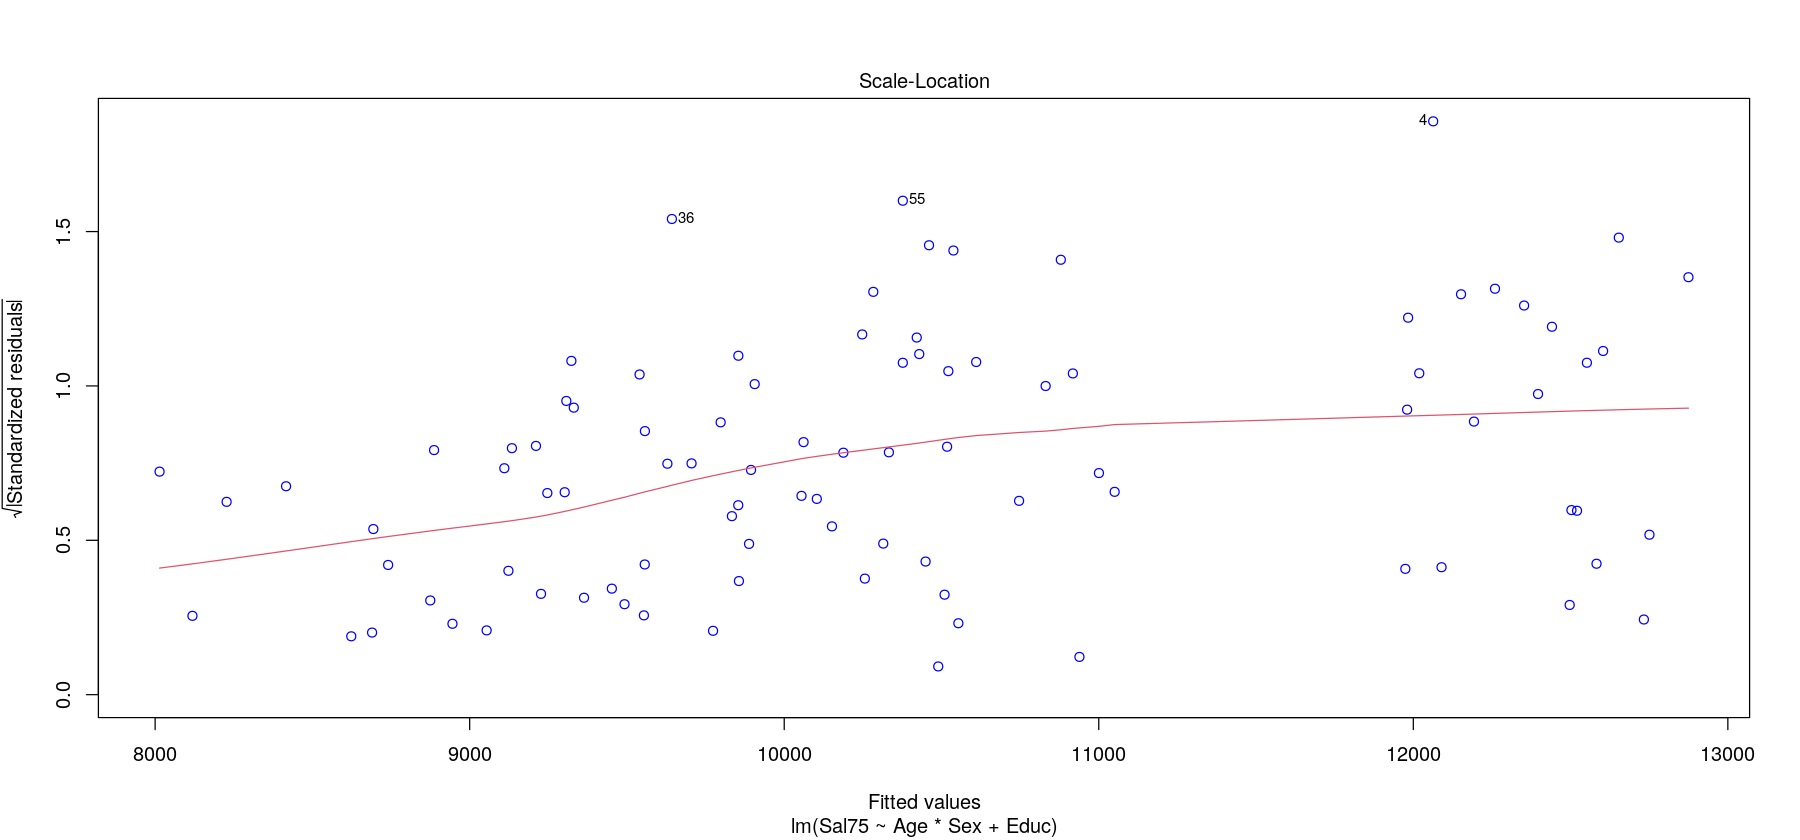

In [96]:
plot(fit_final, which=3, col=c("blue"))

Je vidět, že s rostoucím platem rostou rezidua. Mohlo by být dobré použít robustní regresi, která se umí vypořádat s odlehlými hodnotami, kteří v našem případě můžou být např. manažeři, případně data vhodně transformovat.

In [97]:
ols_test_correlation(fit_final)

[1] 0.9795153

Připouštíme, že jsou rezidua normálně rozdělená a že jsou dobře vysvětlena modelem.